In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rd

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from time import time

In [2]:
df = pd.read_csv('dftrain0420.csv')
df112 = pd.read_csv('dfvalid0420.csv')

df = df.drop(['Unnamed: 0','土地位置建物門牌','交易年月日','建築完成年月',
             'new_date','address','longitude','latitude'],axis=1)

df112 = df112.drop(['Unnamed: 0','土地位置建物門牌','交易年月日','建築完成年月',
             'new_date','address','longitude','latitude'],axis=1)


In [3]:
x = df.drop(['總價元'],axis=1)
y = df['總價元']

In [4]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = x_train.to_numpy()
x_val = x_val.to_numpy()

In [5]:
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)

In [6]:
def compute_error(x, y, w, b):
    y_pred = x @ w + b
    mse = ((y - y_pred)**2).mean()
    rmse = np.sqrt(mse)
    sse = np.sum((y - y_pred)**2)
    sst = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - sse / sst
    return rmse, r2


def compute_grad(x, y, w, b):
    y_pred = x @ w + b
    w_grad = x.T @ (y_pred - y) / x.shape[0]
    b_grad = np.mean(y_pred - y)

    return w_grad, b_grad

def grad(x1, x2, y1, y2, w, b, alpha, run_iter):


    train_rmses = []
    val_rmses = []

    for _ in range(run_iter+1):

        w_grad, b_grad = compute_grad(x1, y1, w, b)

        w -= alpha*w_grad
        b -= alpha*b_grad

        train_rmse = compute_error(x1, y1, w, b)[0]
        val_rmse = compute_error(x2, y2, w, b)[0]

        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
        
    return w, b, train_rmses, val_rmses

In [7]:
alpha = 0.01
run_iter = 10000
w1 = np.zeros(x_train.shape[1])
b1 = 0

start = time()
e1w, e1b, train_rmses1, val_rmses1 = grad(x_train, x_val,
                                        y_train, y_val,
                                        w1, b1,
                                        alpha, run_iter)


end = time()

# 顯示執行時間
print(f'Execution time : {end - start :.3f} seconds')

Execution time : 68.637 seconds


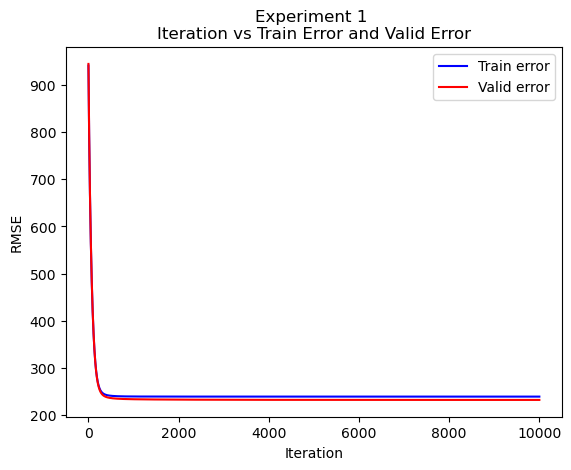

In [8]:
plt.plot(np.arange(run_iter+1), train_rmses1, color='blue', label='Train error')
plt.plot(np.arange(run_iter+1), val_rmses1, color='red', label='Valid error')
plt.title('Experiment 1 \nIteration vs Train Error and Valid Error')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.savefig('e1gd.png')
plt.show()

In [9]:
print('----------Experiment 1----------')

evaluate_name = ['RMSE', 'R^2']
print('Train Error')
for name, error in zip(evaluate_name, compute_error(x_train, y_train, e1w , e1b)):
    print(f'{name} : {error:.6f}')
print('------------------------')
print('Test Error')
for name, error in zip(evaluate_name, compute_error(x_val, y_val, e1w , e1b)):
    print(f'{name} : {error:.6f}')
print('------------------------')

----------Experiment 1----------
Train Error
RMSE : 238.954103
R^2 : 0.709837
------------------------
Test Error
RMSE : 231.924972
R^2 : 0.727802
------------------------


In [10]:
forest_model = RandomForestRegressor().fit(x_train, y_train)

In [11]:
feature_importances = forest_model.feature_importances_

In [12]:
import matplotlib as mpl 
from matplotlib.font_manager import fontManager
fontManager.addfont("ChineseFont.ttf")
mpl.rc('font', family="ChineseFont")

In [13]:
f = {}
for feature, importance in zip(list(x), list(feature_importances)):
    f[feature] = importance
sorted_features = sorted(f.items(), key=lambda i: i[1])

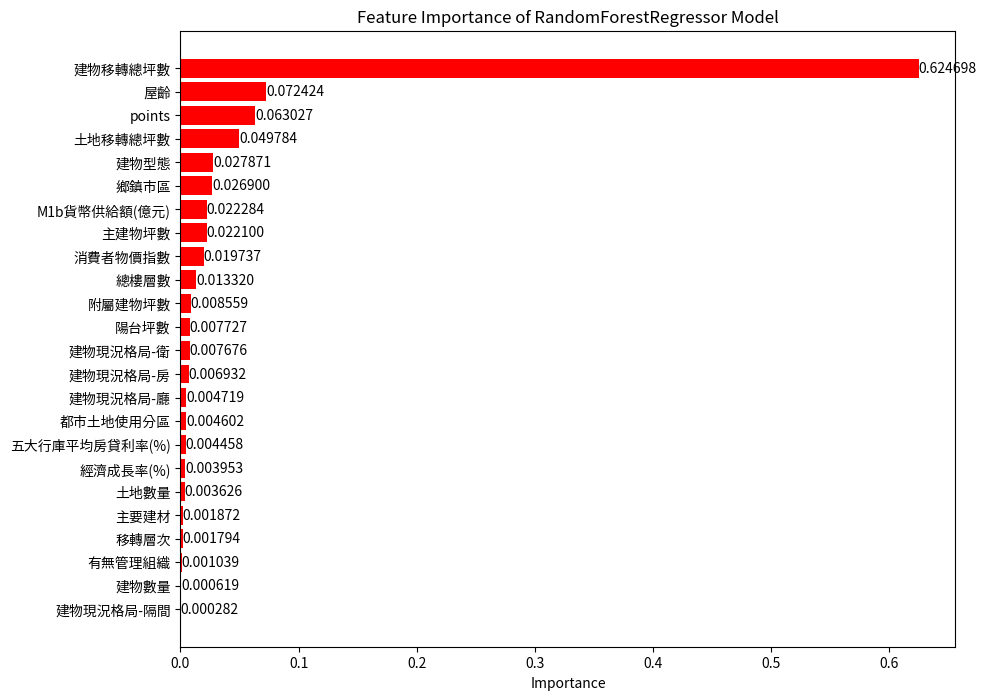

In [14]:
features, importances = zip(*sorted_features)

plt.figure(figsize=(10, 8))
plt.barh(features, importances, color='red')
plt.xlabel('Importance')
plt.title('Feature Importance of RandomForestRegressor Model')


for index, value in enumerate(importances):
    plt.text(value, index, f'{value:.6f}', va='center')
    

plt.show()

In [15]:
median_feature_importances = np.median(feature_importances)

x_train_new = x_train[:, feature_importances >= median_feature_importances]
x_val_new = x_val[:, feature_importances >= median_feature_importances]

In [16]:
start = time()

alpha = 0.01
run_iter = 10000

w2 = np.zeros(x_train_new.shape[1])
b2 = 0

e2w, e2b, train_rmses2, val_rmses2 = grad(x_train_new, x_val_new,
                                        y_train, y_val,
                                        w2, b2,
                                        alpha, run_iter)

end = time()

# 顯示執行時間
print(f'Execution time : {end - start :.3f} seconds')

Execution time : 55.639 seconds


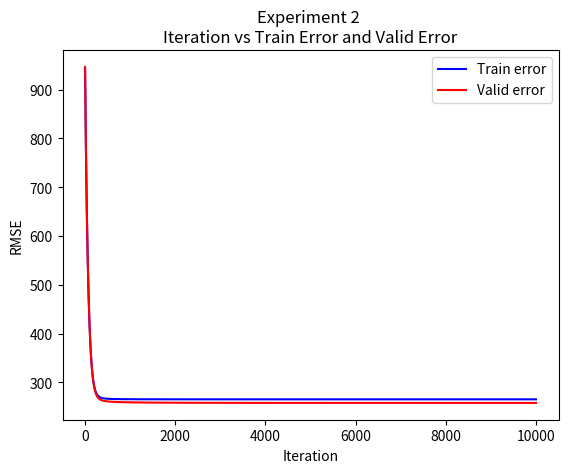

In [17]:
plt.plot(np.arange(run_iter+1), train_rmses2, color='blue', label='Train error')
plt.plot(np.arange(run_iter+1), val_rmses2, color='red', label='Valid error')
plt.title('Experiment 2 \nIteration vs Train Error and Valid Error')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.savefig('e2gd.png')
plt.show()

In [18]:
print('----------Experiment 2----------')

evaluate_name = ['RMSE', 'R^2']
print('Train Error')
for name, error in zip(evaluate_name, compute_error(x_train_new, y_train, e2w , e2b)):
    print(f'{name} : {error:.6f}')
print('------------------------')
print('Test Error')
for name, error in zip(evaluate_name, compute_error(x_val_new, y_val, e2w , e2b)):
    print(f'{name} : {error:.6f}')
print('------------------------')

----------Experiment 2----------
Train Error
RMSE : 265.508670
R^2 : 0.641763
------------------------
Test Error
RMSE : 258.160059
R^2 : 0.662737
------------------------


In [19]:
# 為節省超參數優化時間，故新增一 function 在超參數優化時使用
def gradient_opti_param(x, y, w, b, run_iter, alpha):
    
    for _ in range(run_iter+1):
        
        w_grad, b_grad = compute_grad(x, y, w, b)
        
        w -= w_grad*alpha
        b -= b_grad*alpha
        
    return w, b

In [20]:
# Random Search

# 紀錄開始時間
start = time()

# 定義實驗次數、初始學習率、初始迭代次數、初始誤差
n_iter = 20
best_alpha = None
best_iter = None
best_error = float('inf')
best_w = np.zeros(x_train_new.shape[1])
best_b = None

cv = KFold(n_splits=10, shuffle=True, random_state=42)
    
total_error = []

y_train_array = np.array(y_train)

# 在 n 次實驗中反覆測試
for _ in range(n_iter+1):
    
    # 在(0.01, 0.3) 隨機抽取一數當作學習率
    alpha = rd.choice(np.arange(0.01, 0.31, 0.01))
     
    # 在 [5000, 10000, 15000, 20000] 中隨機抽取一數當作迭代次數
    run_iter = rd.choice([5000, 10000, 15000, 20000])
    
    for train_index, val_index in cv.split(x_train_new, y_train_array):
        x_train_fold, x_val_fold = x_train_new[train_index], x_train_new[val_index]
        y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[val_index]
        
        # 訓練模型
        e3rw, e3rb = gradient_opti_param(x_train_fold, y_train_fold, w2, b2, run_iter, alpha)
        
        # 計算驗證集誤差
        val_error = compute_error(x_val_fold, y_val_fold, e3rw, e3rb)[0]
        total_error.append(val_error)
        
    avg_error = np.mean(total_error)

    # 如果當前誤差小於最佳誤差，則更新最佳學習率、迭代次數與最佳誤差
    if avg_error < best_error:
        best_alpha = alpha
        best_iter = run_iter
        best_error = avg_error
        best_w = e3rw
        best_b = e3rb

# 印出結果
print('Best alpha:', best_alpha)
print('Best run iter:', best_iter)
print('Best error:', best_error)
print('Best w:', best_w)
print('Best b:', best_b)

# 紀錄結束時間
end = time()

# 顯示執行時間
print(f'Execution time : {end - start :.3f} seconds')

Best alpha: 0.08
Best run iter: 5000
Best error: 300.03479827423627
Best w: [  55.90497034    9.8099257   -51.2978846    59.64138713  236.48840757
   94.72174655   -6.00785876  -17.22327887 -121.05189799   40.94955659
   38.11995853   53.76143642]
Best b: 843.1738839165167
Execution time : 2769.854 seconds


In [21]:
# Grid Search

# 紀錄開始時間
start = time()

# 根據隨機搜索結果制定網格搜索範圍
alpha_values = [2*best_alpha/3, best_alpha, 1.5*best_alpha]
iter_values = [best_iter-1000, best_iter, best_iter+1000] 

# 初始學習率、初始迭代次數、初始誤差
best_alpha = None
best_iter = None
best_error = float('inf')
best_w = np.zeros(x_train_new.shape[1])
best_b = None

cv = KFold(n_splits=10, shuffle=True, random_state=42)
    
rmse_list = []

# 在範圍內反覆搜索最小值
for alpha in alpha_values:
    for run_iter in iter_values:
        
        total_error = []
        
        for train_index, val_index in cv.split(x_train_new, y_train_array):
            x_train_fold, x_val_fold = x_train_new[train_index], x_train_new[val_index]
            y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[val_index]
            
            # 訓練模型
            e3gw, e3gb = gradient_opti_param(x_train_fold, y_train_fold, w2, b2, run_iter, alpha)
            
            # 計算驗證集誤差
            val_error = compute_error(x_val_fold, y_val_fold, e3gw, e3gb)[0]
            total_error.append(val_error)
            
        avg_error = np.mean(total_error)

        # 如果當前誤差小於最佳誤差，則更新最佳學習率、迭代次數與最佳誤差
        if avg_error < best_error:
            best_alpha = alpha
            best_iter = run_iter
            best_error = avg_error
            best_w = e3gw
            best_b = e3gb

# 印出結果
print('Best alpha:', best_alpha)
print('Best run iter:', best_iter)
print('Best error:', best_error)
print('Best w:', best_w)
print('Best b:', best_b)

# 紀錄結束時間
end = time()

# 顯示執行時間
print(f'Execution time : {end - start :.3f} seconds')

Best alpha: 0.05333333333333334
Best run iter: 4000
Best error: 300.0345191846948
Best w: [  55.90497034    9.8099257   -51.2978846    59.64138713  236.48840757
   94.72174655   -6.00785876  -17.22327887 -121.05189799   40.94955659
   38.11995853   53.76143642]
Best b: 843.1738839165301
Execution time : 463.621 seconds


In [22]:
run_iter

6000

In [23]:
start = time()

alpha = best_alpha
run_iter = best_iter
w3 = np.zeros(x_train_new.shape[1])
b3 = 0

e3w , e3b, train_rmses3, val_rmses3 = grad(x_train_new, x_val_new, y_train, y_val, w3, b3, alpha, run_iter)

end = time()

# 顯示執行時間
print(f'Execution time : {end - start :.3f} seconds')

Execution time : 22.916 seconds


In [24]:
print('----------Experiment 3----------')

evaluate_name = ['RMSE', 'R^2']
print('Train Error')
for name, error in zip(evaluate_name, compute_error(x_train_new, y_train, e3w, e3b)):
    print(f'{name} : {error:.6f}')
print('------------------------')
print('Valid Error')
for name, error in zip(evaluate_name, compute_error(x_val_new, y_val, e3w, e3b)):
    print(f'{name} : {error:.6f}')
print('------------------------')

----------Experiment 3----------
Train Error
RMSE : 265.508670
R^2 : 0.641763
------------------------
Valid Error
RMSE : 258.159976
R^2 : 0.662737
------------------------


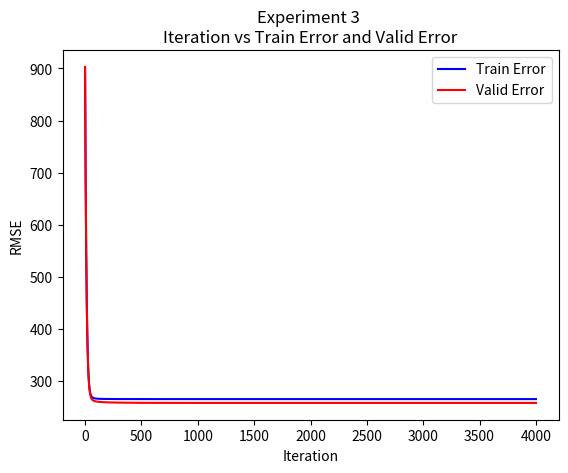

In [25]:
plt.plot(np.arange(0, run_iter+1), train_rmses3, color='blue', label='Train Error')
plt.plot(np.arange(0, run_iter+1), val_rmses3, color='red', label='Valid Error')
plt.title('Experiment 3 \nIteration vs Train Error and Valid Error')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.savefig('e3gd.png')
plt.show()

In [26]:
# 紀錄開始時間
start = time()

# 定義實驗次數、初始學習率、初始迭代次數、初始誤差
n_iter = 20
best_alpha = None
best_iter = None
best_error = float('inf')
best_w = np.zeros(x_train.shape[1])
best_b = None

cv = KFold(n_splits=10, shuffle=True, random_state=42)
    
total_error = []

y_train_array = np.array(y_train)

# 在 n 次實驗中反覆測試
for _ in range(n_iter+1):
    
    # 在(0.01, 0.3) 隨機抽取一數當作學習率
    alpha = rd.choice(np.arange(0.01, 0.31, 0.01))
     
    # 在 [5000, 10000, 15000, 20000] 中隨機抽取一數當作迭代次數
    run_iter = rd.choice([5000, 10000, 15000, 20000])
    
    for train_index, val_index in cv.split(x_train, y_train_array):
        x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
        y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[val_index]
        
        # 訓練模型
        e4rw, e4rb = gradient_opti_param(x_train_fold, y_train_fold, w1, b1, run_iter, alpha)
        
        # 計算驗證集誤差
        val_error = compute_error(x_val_fold, y_val_fold, e4rw, e4rb)[0]
        total_error.append(val_error)
        
    avg_error = np.mean(total_error)

    # 如果當前誤差小於最佳誤差，則更新最佳學習率、迭代次數與最佳誤差
    if avg_error < best_error:
        best_alpha = alpha
        best_iter = run_iter
        best_error = avg_error
        best_w = e4rw
        best_b = e4rb

# 印出結果
print('Best alpha:', best_alpha)
print('Best run iter:', best_iter)
print('Best error:', best_error)
print('Best w:', best_w)
print('Best b:', best_b)

# 紀錄結束時間
end = time()

# 顯示執行時間
print(f'Execution time : {end - start :.3f} seconds')

Best alpha: 0.13
Best run iter: 5000
Best error: 253.53207694448565
Best w: [ 5.77437167e+01  4.30166561e+00  1.94408893e+01  1.14819509e+01
  6.12805822e-02  3.42049414e+01 -9.35357272e+01  2.26395633e+02
  4.22667819e+01  4.97270147e+01  2.21372187e+01 -1.15905196e+01
 -3.41169021e+01  2.23168887e+01  7.18045098e+00 -5.27898754e+00
  9.04318420e+00 -1.29584562e+01 -1.72058105e+02 -4.49945187e+00
  4.60747335e+01  3.76841247e+01 -1.74813851e+00  7.17884107e+01]
Best b: 843.1951406213092
Execution time : 3489.352 seconds


In [27]:
# Grid Search

# 紀錄開始時間
start = time()

# 根據隨機搜索結果制定網格搜索範圍
alpha_values = [2*best_alpha/3, best_alpha, 1.5*best_alpha]
iter_values = [best_iter-1000, best_iter, best_iter+1000]

# 初始學習率、初始迭代次數、初始誤差
best_alpha = None
best_iter = None
best_error = float('inf')
best_w = np.zeros(x_train.shape[1])
best_b = None

cv = KFold(n_splits=10, shuffle=True, random_state=42)
    
rmse_list = []

# 在範圍內反覆搜索最小值
for alpha in alpha_values:
    for run_iter in iter_values:
        
        total_error = []
        
        for train_index, val_index in cv.split(x_train, y_train_array):
            x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
            y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[val_index]
            
            # 訓練模型
            e4gw, e4gb = gradient_opti_param(x_train_fold, y_train_fold, w1, b1, run_iter, alpha)
            
            # 計算驗證集誤差
            val_error = compute_error(x_val_fold, y_val_fold, e4gw, e4gb)[0]
            total_error.append(val_error)
            
        avg_error = np.mean(total_error)

        # 如果當前誤差小於最佳誤差，則更新最佳學習率、迭代次數與最佳誤差
        if avg_error < best_error:
            best_alpha = alpha
            best_iter = run_iter
            best_error = avg_error
            best_w = e4gw
            best_b = e4gb

# 印出結果
print('Best alpha:', best_alpha)
print('Best run iter:', best_iter)
print('Best error:', best_error)
print('Best w:', best_w)
print('Best b:', best_b)

# 紀錄結束時間
end = time()

# 顯示執行時間
print(f'Execution time : {end - start :.3f} seconds')

Best alpha: 0.08666666666666667
Best run iter: 4000
Best error: 253.53205374926583
Best w: [ 5.77437167e+01  4.30166561e+00  1.94408893e+01  1.14819509e+01
  6.12805821e-02  3.42049414e+01 -9.35357272e+01  2.26395633e+02
  4.22667819e+01  4.97270147e+01  2.21372187e+01 -1.15905196e+01
 -3.41169021e+01  2.23168887e+01  7.18045098e+00 -5.27898754e+00
  9.04318420e+00 -1.29584562e+01 -1.72058105e+02 -4.49945187e+00
  4.60747335e+01  3.76841247e+01 -1.74813851e+00  7.17884107e+01]
Best b: 843.1951417341626
Execution time : 582.341 seconds


In [28]:
start = time()

alpha = best_alpha
run_iter = best_iter
w4, b4 = w1, b1

e4w, e4b, train_rmses4, val_rmses4 = grad(x_train, x_val, y_train, y_val, w4, b4, alpha, run_iter)

end = time()

print(f'Execution time : {end - start :.3f} seconds')

Execution time : 30.249 seconds


In [29]:
print('----------Experiment 4----------')


evaluate_name = ['RMSE', 'R^2']
print('Train Error')
for name, error in zip(evaluate_name, compute_error(x_train, y_train, e4w, e4b)):
    print(f'{name} : {error:.6f}')
print('------------------------')
print('Valid Error')
for name, error in zip(evaluate_name, compute_error(x_val, y_val, e4w, e4b)):
    print(f'{name} : {error:.6f}')
print('------------------------')

----------Experiment 4----------
Train Error
RMSE : 238.953940
R^2 : 0.709837
------------------------
Valid Error
RMSE : 231.921063
R^2 : 0.727811
------------------------


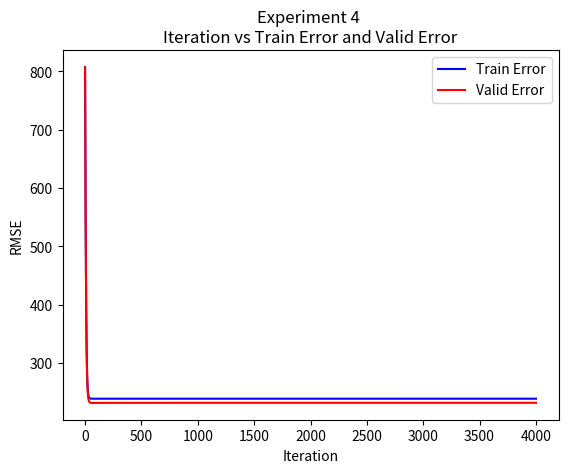

In [30]:
plt.plot(np.arange(0, run_iter+1), train_rmses4, color='blue', label='Train Error')
plt.plot(np.arange(0, run_iter+1), val_rmses4, color='red', label='Valid Error')
plt.title('Experiment 4 \nIteration vs Train Error and Valid Error')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.savefig('e4gd.png')
plt.show()

In [31]:
new_data = df112.drop(['總價元'],axis=1)

In [32]:
new_data = new_data.to_numpy()
scaler = StandardScaler().fit(new_data)
new_data = scaler.transform(new_data)

In [33]:
print('----------Test New Data----------')

evaluate_name = ['RMSE', 'R^2']

for name, error in zip(evaluate_name, compute_error(new_data, df112['總價元'], e4w, e4b)):
    print(f'{name} : {error:.6f}')



----------Test New Data----------
RMSE : 307.185532
R^2 : 0.628644
